In [2]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision import datasets, transforms, utils

from torch.utils.data import DataLoader

from torchmetrics.image.fid import FrechetInceptionDistance

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime
import os
from math import sqrt
import math
import sys
import random

# We can make use of a GPU if you have one on your computer. This works for Nvidia and M series GPU's


if torch.backends.mps.is_available():
    device = torch.device("mps")
    # These 2 lines assign some data on the memory of the device and output it. The output confirms
    # if we have set the intended device
    x = torch.ones(1, device=device)
    print (x)
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
    device = ("cpu")
    x = torch.ones(1, device=device)
    print (x)


'''
device = ("cpu")
x = torch.ones(1, device=device)
print (x)'''
    
    
# I also define a function we use to examine the outputs of the Generator
def show_images(images, num_images=16, figsize=(10,10)):
    # Ensure the input is on CPU
    images = images.cpu().detach()
    
    # Normalize images from [-1, 1] to [0, 1]
    images = (images + 1) / 2
    
    # Clamp values to [0, 1] range
    images = torch.clamp(images, 0, 1)
    
    # Make a grid of images
    grid = torchvision.utils.make_grid(images[:num_images], nrow=4)
    
    # Convert to numpy and transpose
    grid = grid.numpy().transpose((1, 2, 0))
    
    # Display the grid
    plt.figure(figsize=figsize)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

tensor([1.], device='cuda:0')


In [3]:
class EqualLR:
    def __init__(self, name):
        self.name = name
    
    def compute_weight(self, module):
        weight = getattr(module, self.name + '_orig')  
        fan_in = weight.data.size(1) * weight.data[0][0].numel()

        return weight * sqrt(2 / (fan_in))

    @staticmethod
    def apply(module, name):
        fn = EqualLR(name)
        
        weight = getattr(module, name)
        del module._parameters[name]
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        module.register_forward_pre_hook(fn)

        return fn

    def __call__(self, module, input):
        weight = self.compute_weight(module)
        setattr(module, self.name, weight)


def equal_lr(module, name='weight'):
    EqualLR.apply(module, name)

    return module

class EqualLRConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()

        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)


class EqualLRConvTranspose2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.ConvTranspose2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()

        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)

class EqualLRLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        linear = nn.Linear(in_dim, out_dim)
        linear.weight.data.normal_()
        linear.bias.data.zero_()

        self.linear = equal_lr(linear)

    def forward(self, input):
        return self.linear(input)
    

In [4]:
def EMA(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(par2[k].data, alpha=1 - decay) 

In [5]:
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True)
                                  + 1e-8)

In [6]:
class MiniBatchStdDev(nn.Module):
    def __init__(self, group_size=4):
        super().__init__()
        self.group_size = group_size
    
    def forward(self, x):
        N, C, H, W = x.shape 
        G = min(self.group_size, N) 
        
        y = x.view(G, -1, C, H, W)
        
        y = y - torch.mean(y, dim=0, keepdim=True)
        y = torch.mean(torch.square(y), dim=0)
        y = torch.sqrt(y + 1e-8)
        
        y = torch.mean(y, dim=[1,2,3], keepdim=True)
        
        y = y.repeat(G, 1, H, W)
        
        return torch.cat([x,y], dim=1)

In [7]:
class LearnedConstant(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        
        self.constant = nn.Parameter(torch.randn(1, in_c, 4, 4))
        
    def forward(self, batch_size):
        return self.constant.expand(batch_size, -1, -1, -1)

In [8]:
lc = LearnedConstant(256)
lc(4).shape

torch.Size([4, 256, 4, 4])

In [9]:
class NoiseLayer(nn.Module):
    def __init__(self, channels):
        super().__init__()
        
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))
    
    def forward(self, gen_image, noise=None):
        if noise is None:
            N, _, H, W = gen_image.shape
            noise = torch.randn(N, 1, H, W, device=gen_image.device)
        
        return gen_image + (noise * self.weight)

In [10]:
class MappingNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.norm = PixelNorm()
        
        # I set output to 256 to match the shortened G case
        self.layers = nn.Sequential(
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        # Normalise input latent
        x = self.norm(x)
        
        out = self.layers(x)
        
        return out
    
g_mapping_test = MappingNetwork()

In [11]:
test_latent = torch.rand(4, 256)
g_mapping_test(test_latent).shape

torch.Size([4, 256])

In [12]:
test_w = g_mapping_test(test_latent)

map_layer = EqualLRLinear(256, 256*2)
style = map_layer(test_w)

y_s, y_b = style.chunk(2, dim=1)
        
# Reshape y_s and y_b to match x's dimensions
y_s = y_s.unsqueeze(2).unsqueeze(3)
y_b = y_b.unsqueeze(2).unsqueeze(3)

print(y_s.shape, y_b.shape)
print('---')

# Above is old style methodology, Below is new
map_layer = EqualLRLinear(256, 256)
s = map_layer(test_w)
print(f's shape before view: {s.shape}')
s = s.view(-1, 256, 1, 1, 1)  # Expand to match dims of img?
print(f's shape after view: {s.shape}')

print()

# Example w which is the weights of a conv layer
w = nn.Parameter(torch.randn(256, 256, 3, 3))
print(f'w shape before mod: {w.shape}')

w = w * s
print(f'Shape of w after modulation: {w.shape}', '\n')

demod = torch.rsqrt(w.pow(2).sum([2,3,4])+ 1e-8)
print(f'w: {w.shape} | demod: {demod.shape}')
w = w * demod.unsqueeze(2).unsqueeze(3).unsqueeze(4)
print(f'w shape after demod: {w.shape}')

torch.Size([4, 256, 1, 1]) torch.Size([4, 256, 1, 1])
---
s shape before view: torch.Size([4, 256])
s shape after view: torch.Size([4, 256, 1, 1, 1])

w shape before mod: torch.Size([256, 256, 3, 3])
Shape of w after modulation: torch.Size([4, 256, 256, 3, 3]) 

w: torch.Size([4, 256, 256, 3, 3]) | demod: torch.Size([4, 256])
w shape after demod: torch.Size([4, 256, 256, 3, 3])


In [13]:
w.shape

torch.Size([4, 256, 256, 3, 3])

In [14]:
# Testing conv and check size of weights
example_conv = nn.Conv2d(256, 256, 3, padding=1, groups=4)
example_conv.bias = nn.Parameter(example_conv.bias.repeat(4))
print(example_conv.weight.shape)

# Conv2d Expects a 4d tensor as it's weight so we need to convert w to 4d
w = nn.Parameter(w.view(4 * 256, 256, 3, 3))

example_conv.weight = w
print(example_conv.weight.shape)

example_x = torch.randn(4, 256, 4, 4)
example_x = example_x.view(1, 4*256, 4, 4)
print(example_x.shape)

example_out = example_conv(example_x)

print(example_out.shape)
example_out = example_out.view(4, 256, 4, 4)
print(example_out.shape)

print(example_conv.bias.shape)
'''
# Information used in these operations
4 = batch_size
256 = in_channels
'''

torch.Size([256, 64, 3, 3])
torch.Size([1024, 256, 3, 3])
torch.Size([1, 1024, 4, 4])
torch.Size([1, 1024, 4, 4])
torch.Size([4, 256, 4, 4])
torch.Size([1024])


'\n# Information used in these operations\n4 = batch_size\n256 = in_channels\n'

In [15]:
# Testing conv and check size of weights
example_conv = nn.Conv2d(256, 256, 3, padding=1, groups=4)
example_conv.bias = nn.Parameter(example_conv.bias.repeat(4))

# Conv2d Expects a 4d tensor as it's weight so we need to convert w to 4d
w = nn.Parameter(w.view(4 * 256, 256, 3, 3))

example_conv.weight = w

example_x = torch.randn(4, 256, 4, 4)
example_x = example_x.view(1, 4*256, 4, 4)

example_out = example_conv(example_x)

example_out = example_out.view(4, 256, 4, 4)

In [16]:
x = torch.randn(4, 256, 4, 4)
x = x.view(1, 4*256, 4, 4)

w = nn.Parameter(w.view(4 * 256, 256, 3, 3))
groups = 4

out = F.conv2d(x, w, groups=groups, padding=1)
out = out.view(4, -1, out.shape[-2], out.shape[-1])
out.shape

torch.Size([4, 256, 4, 4])

In [17]:
class mod_demod(nn.Module):
    def __init__(self, latent_dim, out_channels):
        super().__init__()
    
        self.map_layer = EqualLRLinear(latent_dim, out_channels)
        self.bias = nn.Parameter(torch.zeros(1, out_channels, 1, 1))

        self.out_channels = out_channels
    def forward(self, w, conv_weight, batch):
        # conv_weight is the weights of the current convolutional layer
        s = self.map_layer(w)
        s = s.view(w.size(0), -1, 1, 1, 1)
        # Add bias and 1 (as per StyleGAN2)
        s = s + 1 + self.bias.view(1, -1, 1, 1, 1)
        # Modulation
        weight = conv_weight * s

        # Demodulation
        demod = torch.rsqrt(weight.pow(2).sum([2,3,4])+ 1e-8)
        weight = weight * demod.unsqueeze(2).unsqueeze(3).unsqueeze(4)

        # Return the weight's of the convolution
        #return nn.Parameter(weight)
        # returning nn.Parameter(weight) caused the latent to have no grad in the ppl regularisation func?!?!
        return weight
        

In [18]:
class Conv2d_mod(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, latent_dim, padding=1):
        super().__init__()

        # The weights for our conv
        self.weights = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        nn.init.normal_(self.weights)

        self.bias = nn.Parameter(torch.zeros(1, out_channels, 1, 1))  # b2 in diagram
        
        self.modulator = mod_demod(latent_dim, out_channels)

        self.eq_lr_scale = sqrt(2 / (in_channels * kernel_size ** 2))

        self.padding = padding
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.latent_dim = latent_dim

    def forward(self, x, style_w):
        batch, channels, H, W = x.shape

        weights = self.weights * self.eq_lr_scale
        # Need to create the modulated and demodulated weights
        weights = self.modulator(style_w, weights, batch)

        #print(f'Channels in x: {channels} | self.in_channels: {self.in_channels} | self.out_channels: {self.out_channels}')

        #print(weights.shape)
        weights = weights.view(batch * self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)
        #weights = weights.view(batch * self.out_channels, channels, self.kernel_size, self.kernel_size)

        x = x.view(1, batch*channels, H, W)
        #print(f'x.shape: {x.shape} | weights.shape: {weights.shape}')
        out = F.conv2d(x, weights, groups=batch, padding=self.padding)
        out = out.view(batch, self.out_channels, out.shape[-2], out.shape[-1])

        out += self.bias
            
        return out
                

In [19]:
conv2d_mod = Conv2d_mod(256, 256, 3, 256)
x = torch.randn(4, 256, 64, 64)
w = torch.randn(4, 256)
conv2d_mod(x, w).shape

torch.Size([4, 256, 64, 64])

In [20]:
conv2d_mod = Conv2d_mod(256, 256//2, 3, 256)
x = torch.randn(4, 256, 128, 128)
w = torch.randn(4, 256)
conv2d_mod(x, w).shape

torch.Size([4, 128, 128, 128])

In [21]:
conv = nn.Conv2d(in_channels=256, out_channels=256//2, kernel_size=3, padding=1)
x = torch.randn(4, 256, 128, 128)
w = torch.randn(4, 256)
conv(x).shape

torch.Size([4, 128, 128, 128])

In [22]:
class g_style_block(nn.Module):
    def __init__(
        self, 
        in_c, 
        out_c, 
        ksize1, 
        padding,
        upsample=True,
        latent_dim=256,
    ):
        super().__init__()

        layers_list = []

        if upsample:
            layers_list.extend([
                nn.Upsample(scale_factor=2, mode='bilinear'),
                #Conv2d_mod(in_c, out_c, ksize1, latent_dim, padding=padding),  # Will need to provide style_w and x
                #EqualLRConv2d(in_c, out_c, ksize1, latent_dim, padding=padding),
                nn.Conv2d(in_channels=in_c, out_channels=out_c, kernel_size=ksize1, padding=padding),
                NoiseLayer(out_c),
            ])
        else:
            self.learned_constant = LearnedConstant(in_c)

        layers_list.extend([
            nn.LeakyReLU(0.2),
            #Conv2d_mod(out_c, out_c, ksize1, latent_dim, padding=padding),
            #EqualLRConv2d(out_c, out_c, ksize1, latent_dim, padding=padding),
            nn.Conv2d(in_channels=out_c, out_channels=out_c, kernel_size=ksize1, padding=padding),
            NoiseLayer(out_c),
            nn.LeakyReLU(0.2),
        ])

        self.layers = nn.ModuleList(layers_list)
        self.upsample = upsample
        
    def forward(self, w, x=None):
        if not self.upsample:
            x = self.learned_constant(w.size(0))
        
        for layer in self.layers:
            #print(layer)
            #print(f'x.shape: {x.shape}')
            if isinstance(layer, LearnedConstant):
                x = layer()
            elif isinstance(layer, nn.Conv2d):
                x = layer(x)
            else:
                x = layer(x)
            
        return x
                

In [29]:
class Generator(nn.Module):
    def __init__(self, in_c=256):
        super().__init__()
        
        self.g_mapping = MappingNetwork()
        
        self.block_4x4 = g_style_block(in_c, in_c, 3, 1, upsample=False)
        self.block_8x8 = g_style_block(in_c, in_c, 3, 1)
        self.block_16x16 = g_style_block(in_c, in_c, 3, 1)
        self.block_32x32 = g_style_block(in_c, in_c, 3, 1)
        self.block_64x64 = g_style_block(in_c, in_c//2, 3, 1)
        self.block_128x128 = g_style_block(in_c//2, in_c//4, 3, 1)
        self.block_256x256 = g_style_block(in_c//4, in_c//4, 3, 1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.to_rgb_4 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_8 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_16 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_32 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_64 = EqualLRConv2d(in_c//2, 3, 1)
        self.to_rgb_128 = EqualLRConv2d(in_c//4, 3, 1)
        self.to_rgb_256 = EqualLRConv2d(in_c//4, 3, 1)
                
        self.tanh = nn.Tanh()

    def forward(self, z, return_latents=False):   
        w = self.g_mapping(z)
        
        if torch.rand(1).item() < 0.9:
            z2 = torch.randn_like(z)
            w2 = self.g_mapping(z2)

            crossover_point = random.randint(1, 7)
        else:
            crossover_point = None

        w_to_use = w2 if crossover_point and 1 >= crossover_point else w
        out = self.block_4x4(w_to_use)      
        
        out_4 = self.to_rgb_4(out)
        out_4 = self.upsample(out_4)

        w_to_use = w2 if crossover_point and 2 >= crossover_point else w
        out = self.block_8x8(w_to_use, out)
        
        out_8 = self.to_rgb_8(out)
        out_8 += out_4
        out_8 = self.upsample(out_8)
            
        w_to_use = w2 if crossover_point and 3 >= crossover_point else w
        out = self.block_16x16(w_to_use, out)
        
        out_16 = self.to_rgb_16(out)
        out_16 += out_8
        out_16 = self.upsample(out_16)

        w_to_use = w2 if crossover_point and 4 >= crossover_point else w
        out = self.block_32x32(w_to_use, out)
        
        out_32 = self.to_rgb_32(out)
        out_32 += out_16
        out_32 = self.upsample(out_32)

        w_to_use = w2 if crossover_point and 5 >= crossover_point else w
        out = self.block_64x64(w_to_use, out)
        
        out_64 = self.to_rgb_64(out)
        out_64 += out_32
        out_64 = self.upsample(out_64)

        w_to_use = w2 if crossover_point and 6 >= crossover_point else w    
        out = self.block_128x128(w_to_use, out)
        
        out_128 = self.to_rgb_128(out)
        out_128 += out_64
        out_128= self.upsample(out_128)

        w_to_use = w2 if crossover_point and 7 >= crossover_point else w
        out = self.block_256x256(w_to_use, out)
            
        out_256 = self.to_rgb_256(out)
        out_256 += out_128
        
        if return_latents:
            return out_256, w_to_use
        else:
            return out_256

g = Generator().to(device)

In [30]:
print(g)

Generator(
  (g_mapping): MappingNetwork(
    (norm): PixelNorm()
    (layers): Sequential(
      (0): EqualLRLinear(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (1): LeakyReLU(negative_slope=0.2)
      (2): EqualLRLinear(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (3): LeakyReLU(negative_slope=0.2)
      (4): EqualLRLinear(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (5): LeakyReLU(negative_slope=0.2)
      (6): EqualLRLinear(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (7): LeakyReLU(negative_slope=0.2)
      (8): EqualLRLinear(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (9): LeakyReLU(negative_slope=0.2)
      (10): EqualLRLinear(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (11): LeakyReLU(negative_slope=0.2)
      (12): EqualLRLinear(
   

block 4x4 out shape: torch.Size([4, 256, 4, 4])
block 8x8 out shape: torch.Size([4, 256, 8, 8])
block 16x16 out shape: torch.Size([4, 256, 16, 16])


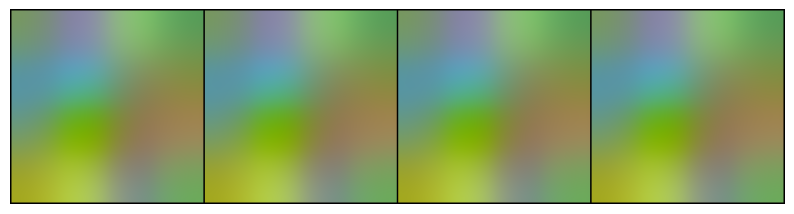

(None, torch.Size([4, 3, 256, 256]))

In [31]:
# TESTING G
g_in = torch.randn(4, 256, device=device)
g_out, _ = g(g_in, return_latents=True)
show_images(g_out), g_out.shape

In [32]:
class Blur(nn.Module):
    def __init__(self):
        super().__init__()
        f = torch.Tensor([1, 2, 1])
        self.register_buffer('f', f)

    def forward(self, x):
        f = self.f
        f = f[None, None, :] * f[None, :, None]
        f = f / f.sum()
        return F.conv2d(x, f.expand(x.size(1), -1, -1, -1), 
                        groups=x.size(1), padding=(1,1))

In [33]:
# example of blur
sample = torch.randn(1, 3, 64, 64)
blur = Blur()

blur(sample).shape

torch.Size([1, 3, 64, 64])

In [34]:
class d_style_block(nn.Module):
    def __init__(
        self,
        in_c,
        out_c,
        ksize1, 
        padding,  
        ksize2=None, 
        padding2=None,
        stride=None,   
        mbatch=False,
    ):
        super().__init__()

        if ksize2 is None:
            ksize2 = ksize1
        if padding2 is None:
            padding2 = padding
        
        layers_list = []

        # TODO Add ConvBlurPool (strided conv with blur) - Not sure if needed???
        self.down_res = nn.Sequential(
            Blur(),
            EqualLRConv2d(in_c, out_c, 3, padding = 1, stride=2),
            EqualLRConv2d(out_c, out_c, 2, padding=0, stride=1) if mbatch else nn.Identity()  # Needed for last layer otherwise res 
            # has two H, W instead of 1
        )
        
        if mbatch:
            layers_list.extend([
                MiniBatchStdDev(),
            ])
            in_c += 1
            
        layers_list.extend([
            EqualLRConv2d(in_c, in_c, ksize1, padding=padding),
            nn.LeakyReLU(0.2),
            EqualLRConv2d(in_c, out_c, ksize2, padding=padding2),
            nn.LeakyReLU(0.2),
        ])

        if not mbatch:  # No downsample if we are on the last layer
            layers_list.extend([
                EqualLRConv2d(out_c, out_c, 3, padding=1, stride=2)
            ])
        
        self.layers = nn.ModuleList(layers_list)
    
    def forward(self, x):
        res = self.down_res(x)
        for layer in self.layers:
            #print(layer)
            #print(f'x.shape: {x.shape}')
            x = layer(x)

        #print(f'res.shape: {res.shape} | x.shape: {x.shape}')
        out = (res + x) * (1/ sqrt(2))       
        
        return out

In [35]:
class Discriminator(nn.Module):
    def __init__(self, out_c=256):
        super().__init__()

        self.from_rgb = EqualLRConv2d(3, out_c//4, 1)

        self.block_256x256 = d_style_block(out_c//4, out_c//4, 3, 1)
        self.block_128x128 = d_style_block(out_c//4, out_c//2, 3, 1)
        self.block_64x64 = d_style_block(out_c//2, out_c, 3, 1)
        self.block_32x32 =  d_style_block(out_c, out_c, 3, 1)
        self.block_16x16 = d_style_block(out_c, out_c, 3, 1)
        self.block_8x8 = d_style_block(out_c, out_c, 3, 1)
        self.block_4x4 = d_style_block(out_c, out_c, 3, 1, 4, 0, mbatch=True)

        self.linear = EqualLRLinear(out_c, 1)

    def forward(self, x):
        
        out = self.from_rgb(x)

        out = self.block_256x256(out)
        out = self.block_128x128(out)
        out = self.block_64x64(out)
        out = self.block_32x32(out)
        out = self.block_16x16(out)
        out = self.block_8x8(out)
        out = self.block_4x4(out)

        #print(out.shape)
        out = out.view(out.size(0), -1)
        #print(out.shape)
        out = self.linear(out)

        return out

d = Discriminator().to(device)

In [36]:
rand_img = torch.randn(4, 3, 256, 256).to(device)
d_out = d(rand_img)
d_out

tensor([[12.0543],
        [ 9.7922],
        [ 8.8082],
        [ 9.3687]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
# R1 regulariser uses the Goodfellow GAN training algorithm
def d_loss(real_images, gen_images):
    # Do this outside the func
    real_pred = d(real_images)
    fake_pred = d(gen_images)

    real_loss = F.softplus(-real_pred).mean()
    fake_loss = F.softplus(fake_pred).mean()

    d_loss = real_loss + fake_loss

    return d_loss

def r1_loss(real_pred, real_images):
    grad_real, = torch.autograd.grad(
        outputs=real_pred.sum(), inputs=real_images, create_graph=True
    )
    grad_penalty = grad_real.pow(2).reshape(grad_real.shape[0], -1).sum(1).mean()

    return grad_penalty

def g_loss(fake_pred):
    fake_loss = F.softplus(-fake_pred).mean()

    return fake_loss


# Credit: https://github.com/rosinality/stylegan2-pytorch/blob/master/train.py#L87
def g_path_regularize(fake_img, latents, mean_path_length, decay=0.01):
    noise = torch.randn_like(fake_img) / math.sqrt(
        fake_img.shape[2] * fake_img.shape[3]
    )
    
    outputs = (fake_img * noise).sum()
    
    grad, = torch.autograd.grad(
        outputs=outputs, inputs=latents, create_graph=True
    )
    
    path_lengths = torch.sqrt(grad.pow(2).sum(1).mean(0))
    path_mean = mean_path_length + decay * (path_lengths.mean() - mean_path_length)
    path_penalty = (path_lengths - path_mean).pow(2).mean()
    
    return path_penalty, path_mean.detach(), path_lengths

In [62]:
#z = torch.randn(1, 256, device=device)
#gen_imgs, latents = g(z, return_latents=True)

#g_path_regularize(gen_imgs, latents, mean_path_length)

In [63]:
grads = torch.randn(4, 256, 4, 4)
grads.reshape(grads.shape[0], -1).shape

torch.Size([4, 4096])

In [64]:
def get_dataloader(image_size, batch_size=8):
    # Just some basic transforms, image_size holds the resolution of the current layer
    # so we create a new dataloader after stabilising each layer
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize images to the required size
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # I assume your CelebA HQ 256 directory is in the same one as this notebook, feel free to change it
    dataset = ImageFolder(root='./celeba_hq_256', transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

    return dataloader

# To get the params for the mapping network we look for parameters with "mapping" in the name
def get_params_with_lr(model):
    mapping_params = []
    other_params = []
    for name, param in model.named_parameters():
        if 'mapping' in name:  # Adjust this condition based on your actual naming convention
            mapping_params.append(param)
        else:
            other_params.append(param)
    return mapping_params, other_params
# To illustrate how this works look at this
for name, param in g.named_parameters():
    print(name)
# The naming convetion of PyTorch has the module name at the start. This is what we take advantage of

g_mapping.layers.0.linear.bias
g_mapping.layers.0.linear.weight_orig
g_mapping.layers.2.linear.bias
g_mapping.layers.2.linear.weight_orig
g_mapping.layers.4.linear.bias
g_mapping.layers.4.linear.weight_orig
g_mapping.layers.6.linear.bias
g_mapping.layers.6.linear.weight_orig
g_mapping.layers.8.linear.bias
g_mapping.layers.8.linear.weight_orig
g_mapping.layers.10.linear.bias
g_mapping.layers.10.linear.weight_orig
g_mapping.layers.12.linear.bias
g_mapping.layers.12.linear.weight_orig
g_mapping.layers.14.linear.bias
g_mapping.layers.14.linear.weight_orig
block_4x4.learned_constant.constant
block_4x4.layers.1.weights
block_4x4.layers.1.bias
block_4x4.layers.1.modulator.bias
block_4x4.layers.1.modulator.map_layer.linear.bias
block_4x4.layers.1.modulator.map_layer.linear.weight_orig
block_4x4.layers.2.weight
block_8x8.layers.1.weights
block_8x8.layers.1.bias
block_8x8.layers.1.modulator.bias
block_8x8.layers.1.modulator.map_layer.linear.bias
block_8x8.layers.1.modulator.map_layer.linear.weig

In [65]:
# Now sample 30k fake and add them to fid
def resize(images):
    # Resize to 299x299, the inception v3 model expects 299,299 images so we just resize our images to
    # this size
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
    ])
    return transform(images)

# We make use of the FID class provided by the torchmetrics library provided by PyTorch Lightning
# This class works by "adding" fake and real images to the model
# So I create two functions, one for adding fake images and one for real images
def add_fake_images(g_running, num_images, batch_size, latent_dim, device):
    # The function takes in g_running and all params needed to generate images
    # we use g_running in this function as it is the model we use to output our fake images
    g_running.eval()
    
    # Set torch.no_grad to turn off gradients, it makes the code run faster and use less memory as gradients
    # aren't tracked
    with torch.no_grad():
        # Generate 30000 images to pass to the FID model, we pass them as we generate them to save
        # images
        for _ in tqdm(range(0, num_images, batch_size), desc="Generating images"):
            z = torch.randn(batch_size, latent_dim, device=device)
            batch_images = g_running(z)
        
            # resize images
            resize_batch = resize(batch_images)
            # Inception v3 requires pixel ranges to be [0,255] currently it's [-1,1], 
            # this line handles the conversion
            resize_batch = ((resize_batch + 1) * 127.5).clamp(0, 255)
            # Inception v3 also expects input data type to be uint8, this can be handled with a simple cast
            resize_batch = resize_batch.to(torch.uint8)
            
            # Update FID
            fid.update(resize_batch, real=False)
            
            # Clear GPU cache, to save memory
            torch.cuda.empty_cache()

# The second function just takes in the data_loader as a parm
def add_real_imgs(data_loader):
    # we pass all batches to the FID model i.e. 30k images
    for batch in tqdm(data_loader, desc="Processing real images"):
        imgs, _ = batch
        # Resize, convert to [0,255] range and cast to uint8 as before
        imgs = resize(imgs)
        imgs = imgs.to(device)
        imgs = ((imgs + 1) * 127.5).clamp(0, 255)
        imgs = imgs.to(torch.uint8)
        fid.update(imgs, real=True)

# Final function which combines both of the image adding functions
def calculate_and_save_fid(iteration, data_loader, g_running, num_fake_images, batch_size, latent_dim, device, fid_file):
    # We reset the FID score statistics for recalculation
    fid.reset()
    # Add the real and fake images
    add_fake_images(g_running, num_fake_images, batch_size, latent_dim, device)
    add_real_imgs(data_loader)
    # Compute FID score and output it
    fid_score = fid.compute()
    print(f"FID score for iteration {iteration}: {fid_score.item()}")
    
    # We also save the scores to a file
    with open(fid_file, 'a') as f:
        f.write(f"Iteration {iteration}: {fid_score.item()}\n")

Starting training from the beginning
Training resolution: 256x256, Batch size: 16


  0%|          | 0/800000 [00:00<?, ?it/s]

G_running images images after iter: 0


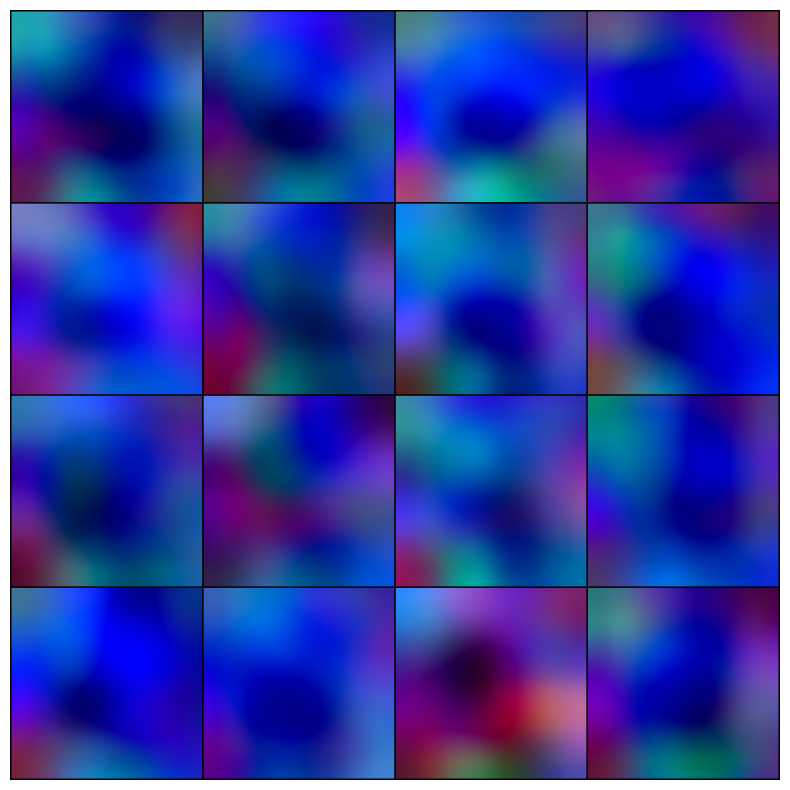

Generating images:   0%|          | 0/1875 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [66]:
# Create new checkpoint dir with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join('./checkpoints', f'run_{timestamp}')
checkpoint_dir = os.path.join(run_dir, f"checkpoint_{timestamp}")
sample_dir = os.path.join(run_dir, f"sample_{timestamp}")
# Create a file to log FID scores
fid_file = os.path.join(run_dir, 'fid.txt')

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)

# Init models
g = Generator().to(device)
d = Discriminator().to(device)
g_running = Generator().to(device)

g_running.train(False)

fid = FrechetInceptionDistance(feature=2048).to(device)

mapping_params, other_params = get_params_with_lr(g)

lr = 0.002
mapping_lr = 0.001 * 0.01
g_optimizer = torch.optim.Adam([
    {'params': mapping_params, 'lr': mapping_lr},  # 0.01 * LR for mapping network
    {'params': other_params, 'lr': lr}  # Regular LR for other parts
], betas=(0.0, 0.99))
d_optimizer = torch.optim.Adam(d.parameters(), lr=lr, betas=(0.0, 0.99))

start_iter = 0

resume_checkpoint = False
if resume_checkpoint:
    if os.path.isfile(resume_checkpoint):
        print(f"=> loading checkpoint '{resume_checkpoint}'")
        checkpoint = torch.load(resume_checkpoint, weights_only=False)
        start_iter = checkpoint['iteration'] + 1
        g.load_state_dict(checkpoint['g_state_dict'])
        d.load_state_dict(checkpoint['d_state_dict'])
        g_running.load_state_dict(checkpoint['g_running_state_dict'])
        g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])

        print(f"=> loaded checkpoint '{resume_checkpoint}' (layer {start_layer}, iteration {start_iter})")
    else:
        print(f"=> no checkpoint found at '{resume_checkpoint}'")
else:
    print("Starting training from the beginning")

# Init EMA 
EMA(g_running, g, 0)

# We evaluate FID every 10k iterations
num_iters_for_eval = 10000

# We want to gen 30k fake images for FID calculation to match 30k real images
num_fake_images = 30000
latent_dim = 256  # Adjust based on your model's input size

# Define vars used within training loop
d_loss_val = None
g_loss_val = None
r1_loss_val = None
mean_path_length = 0

resolution = 256  # Resolution is always 256
batch_size = 16  # CHANGE to 32
total_iters = 800000
data_loader = get_dataloader(resolution, batch_size)
dataset = iter(data_loader)

# Init a progress bar
print(f'Training resolution: {resolution}x{resolution}, Batch size: {batch_size}')
pbar = tqdm(range(total_iters))

# Begin introducing layer phase
for i in pbar:
    d.zero_grad()
    
    try:
        real_imgs, label = next(dataset)
    except (OSError, StopIteration):
        # If we reach the end of the dataset, we reintialise the iterable
        # basically starting again
        dataset = iter(data_loader)
        real_imgs, label = next(dataset)

    # Train D
    real_size = real_imgs.size(0)
    real_imgs = real_imgs.to(device)
    label = label.to(device)
    real_preds = d(real_imgs)
    # The line below implements a small weight penalty
    # It ensures the D loss isnt too far away from 0 preventing extreme outputs 
    real_preds = real_preds.mean() - 0.001 * (real_preds**2).mean()

    # Create gen images and gen preds
    z = torch.randn(real_size, 256, device=device)
    gen_imgs = g(z)
    gen_preds = d(gen_imgs)
    
    d_loss_val = d_loss(real_imgs, gen_imgs)
    
    d_loss_val.backward()
    d_optimizer.step()

    # Implement a way to run r1 reg every 16 batches

    d_r1_regularise = i % 16 == 0
    if d_r1_regularise:
        real_imgs.requires_grad_(True)

        real_preds = d(real_imgs)

        r1_loss_val = r1_loss(real_preds, real_imgs)

        d.zero_grad()
        gamma = 10
        # *16 from appendix b
        r1_reg = (gamma/2 * r1_loss_val * 16 * real_imgs.size(0))
        r1_reg.backward()

        d_r1_regularise = False

    # Now lets train the Generator
    g.zero_grad()

    z = torch.randn(real_size, 256, device=device)
    gen_imgs = g(z)
    gen_preds = d(gen_imgs)

    g_loss_val = g_loss(gen_preds)
    
    g_loss_val.backward()
    g_optimizer.step()

    # PPL reg, r1 only used on D
    # PPL a metric for gen images only
    g_ppl_regularise = i % 8 == 0
    if g_ppl_regularise:
        z = torch.randn(real_size, 256, device=device)
        gen_imgs, latents = g(z, return_latents=True)  # PPL calculation relies on latent vectors which produced imgs
        
        ppl_loss, mean_path_length, path_lengths = g_path_regularize(gen_imgs, latents, mean_path_length)

        g.zero_grad()
        
        ppl_loss = 2 * 8 * ppl_loss
        ppl_loss.backward()

        g_optimizer.step()
        
    EMA(g_running, g)

    if i % num_iters_for_eval == 0:
        sample_z = torch.randn(16, 256, device=device)
        sample_imgs_EMA = g_running(sample_z)
        save_image(sample_imgs_EMA, f'{sample_dir}/sample__iter_{i}.png', nrow=4, normalize=True)
        print(f'G_running images images after iter: {i}')
        show_images(sample_imgs_EMA)

        calculate_and_save_fid(i, data_loader, g_running, num_fake_images, batch_size, latent_dim, device, fid_file)

with torch.no_grad():
    sample_z = torch.randn(16, 256, device=device)
    sample_imgs = g(sample_z)
    sample_imgs_EMA = g_running(sample_z)

    calculate_and_save_fid('final', data_loader, g_running, num_fake_images, batch_size, latent_dim, device, fid_file)

# No need for stabilising period

torch.save({
    'g_state_dict': g.state_dict(),
    'g_running_state_dict': g_running.state_dict(),
    'd_state_dict': d.state_dict(),
    'g_optimizer_state_dict': g_optimizer.state_dict(),
    'd_optimizer_state_dict': d_optimizer.state_dict(),
    'iteration': i
}, f'{checkpoint_dir}/completed_checkpoint_g_and_EMA.pth')